<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

<img src='http://www.comeneat.com/blog/wp-content/uploads/2018/11/FacebookChallenge1.png'></img>

In [8]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [1]:
#reading
from pandas import read_hdf
df_final_train1 = read_hdf('storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test1 = read_hdf('storage_sample_stage5.h5', 'test_df',mode='r')
df_final_train2 = read_hdf('storage_sample_stage6.h5', 'train_df',mode='r')
df_final_test2 = read_hdf('storage_sample_stage6.h5', 'test_df',mode='r')
df_final_train3 = read_hdf('storage_sample_stage7.h5', 'train_df',mode='r')
df_final_test3 = read_hdf('storage_sample_stage7.h5', 'test_df',mode='r')

In [2]:
df_final_train1 = df_final_train1.drop(['preferential_attachment_followers','preferential_attachment_followees'] , axis=1)

In [3]:
print(df_final_train1.columns)
df_final_test1 = df_final_test1.drop(['preferential_attachment_followers','preferential_attachment_followees'] , axis=1)
print(df_final_test1.columns)

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')
Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_follow

In [4]:
print(df_final_train2.columns)
df_final_train2.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test2.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Index(['source_node', 'destination_node', 'indicator_link', 'svd_dot_U',
       'svd_dot_V.T'],
      dtype='object')


In [5]:
print(df_final_train3.columns)
df_final_train3.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test3.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Index(['source_node', 'destination_node', 'indicator_link',
       'preferential_attachment'],
      dtype='object')


In [9]:
df_final_train=pd.concat((df_final_train1,df_final_train2,df_final_train3),axis=1)
df_final_test=pd.concat((df_final_test1,df_final_test2,df_final_test3),axis=1)

In [10]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [11]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [14]:
df_final_test.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot_U,svd_dot_V.T,preferential_attachment
0,0,0.000000,0.029161,0.000000,6,14,6,9,1,0,...,5.535483e-14,-9.994074e-10,5.791905e-10,3.512350e-07,2.486659e-09,2.771126e-09,1.727685e-12,43245344535478792,43245344535478792,54
1,0,0.000000,0.000000,0.000000,5,9,12,13,0,0,...,1.959114e-14,-9.985893e-10,2.765230e-12,2.663041e-10,3.127474e-12,6.898113e-13,9.808653e-14,43245344535478792,43245344535478792,63
2,0,0.030303,0.038888,0.091287,5,23,4,30,2,1,...,2.972265e-14,-1.798014e-12,9.585623e-10,8.079360e-11,9.762535e-12,1.382136e-11,1.064857e-13,43245344535478792,43245344535478792,0
3,0,0.000000,0.000000,0.000000,14,0,13,2,0,0,...,6.820558e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,43245344535478792,43245344535478792,20
4,0,0.096154,0.035194,0.177667,24,29,24,33,5,5,...,1.350467e-13,-8.275107e-12,5.829706e-12,3.973169e-10,2.105173e-11,2.150128e-11,8.063779e-14,43245344535478792,43245344535478792,4


In [15]:
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,inter_followers,inter_followees,...,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot_U,svd_dot_V.T,preferential_attachment
0,0,0.000000,0.0,0.000000,11,6,15,8,0,0,...,1.719704e-14,-1.355368e-12,4.675318e-13,1.128586e-06,6.616690e-14,9.770992e-13,4.160012e-14,86374215336216075,86374215336216075,120
1,0,0.142857,0.1,0.251976,4,5,9,7,1,2,...,3.764978e-14,-9.654310e-14,2.094676e-13,2.322274e-12,3.105556e-11,7.298549e-13,4.893594e-14,86374215336216075,86374215336216075,40
2,0,0.000000,0.0,0.000000,113,130,56,110,0,0,...,5.012045e-12,-1.163263e-09,8.376298e-11,7.250767e-05,3.046345e-11,9.080483e-10,4.314006e-12,86374215336216075,86374215336216075,115
3,0,0.000000,0.0,0.000000,18,3,20,2,0,0,...,1.675996e-13,-4.543612e-13,8.028296e-14,4.822147e-08,8.977866e-14,2.758034e-13,1.589702e-15,86374215336216075,86374215336216075,40
4,0,0.000000,0.0,0.000000,23,1,18,3,0,0,...,4.023492e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,86374215336216075,86374215336216075,4872


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7febb022b160>,
      dtype=object)

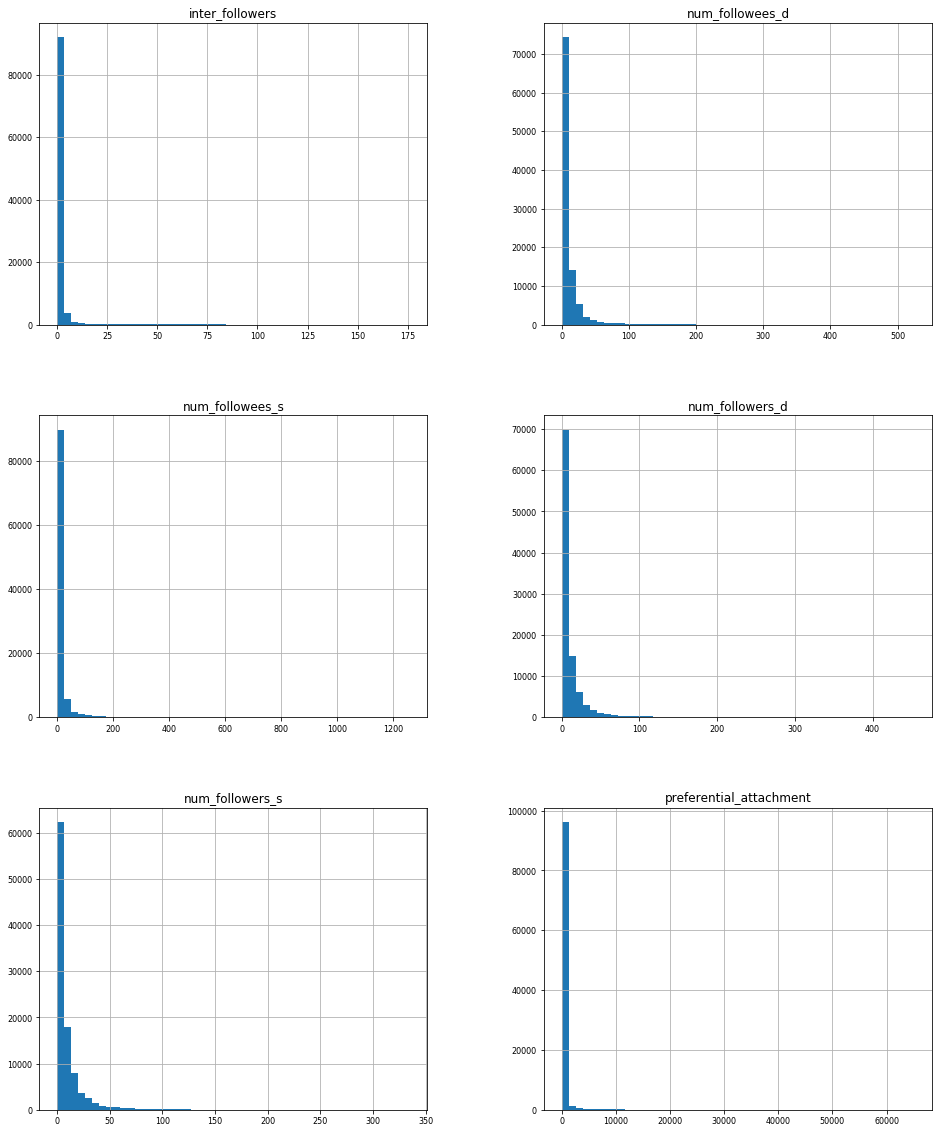

In [29]:
df_num = df_final_train[['preferential_attachment','num_followers_s','num_followers_d','num_followees_s','num_followees_d','inter_followers']]
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [ ]:
from sklearn.manifold import TSNE
X_2d = TSNE(n_components=2).fit_transform(df_final_train)

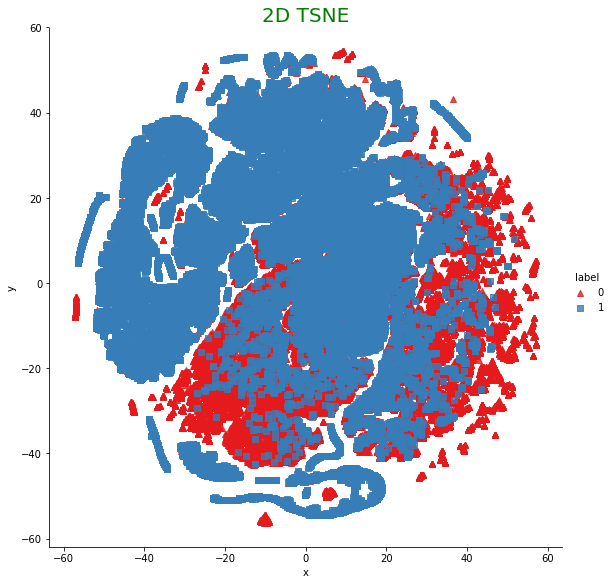

In [146]:
df = pd.DataFrame({'x' : X_2d[:, 0], 'y' : X_2d[:, 1], 'label' : y_train})
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=8,palette="Set1", markers=['^', 's'])
plt.title(fontsize=20, color='g' ,label='2D TSNE')
plt.show()

### Hyperparameter Tuning on estimators (Random Forest Classifier)

Estimators =  10 Train Score 0.931098075580608 test Score 0.9214326131148228
Estimators =  50 Train Score 0.9333026149061168 test Score 0.9246233273627648
Estimators =  100 Train Score 0.9329610691093893 test Score 0.9243428667634741
Estimators =  250 Train Score 0.9338112756658177 test Score 0.9256962025316455
Estimators =  450 Train Score 0.9336032133905255 test Score 0.9248415716096325


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

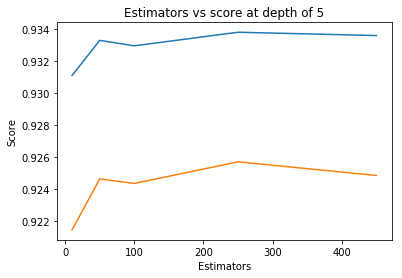

In [158]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

### Hyperparameter Tuning on depths (Random Forest Classifier)

depth =  3 Train Score 0.9219550071350625 test Score 0.9092989258246996
depth =  9 Train Score 0.9620513241971606 test Score 0.930929663092122
depth =  11 Train Score 0.972689267950322 test Score 0.9312751734463635
depth =  15 Train Score 0.9749185436311777 test Score 0.9328809558931996
depth =  20 Train Score 0.9755860167085731 test Score 0.9325667593294583
depth =  35 Train Score 0.97532579483799 test Score 0.9326564573547068
depth =  50 Train Score 0.97532579483799 test Score 0.9326564573547068
depth =  70 Train Score 0.97532579483799 test Score 0.9326564573547068
depth =  130 Train Score 0.97532579483799 test Score 0.9326564573547068


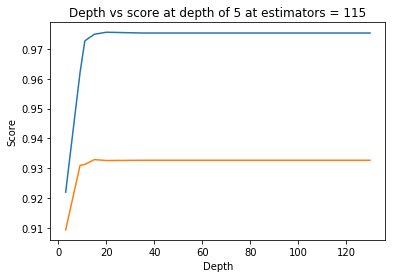

In [159]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

### Hyperparameter Tuning on n_estimators,max_depth,min_samples_split,min_samples_leaf (Random Forest Classifier)

In [160]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.97250114 0.97255904 0.96980558 0.97206742 0.97397522]
mean train scores [0.97357576 0.97364472 0.97092132 0.97328164 0.97536098]


In [161]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [162]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [163]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [164]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9759611969680058
Test f1 score 0.9319274567692956


In [165]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


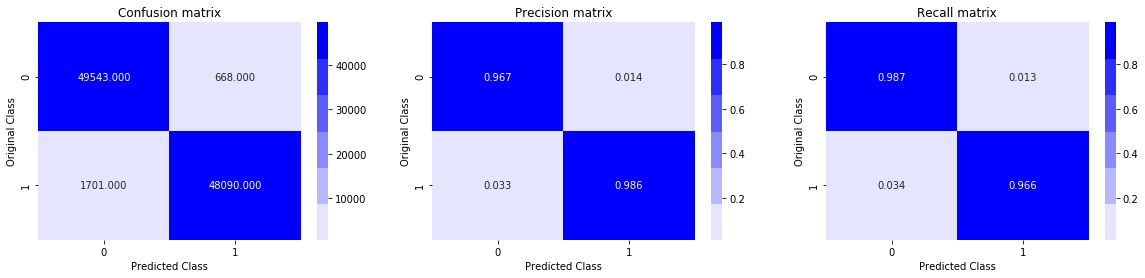

Test confusion_matrix


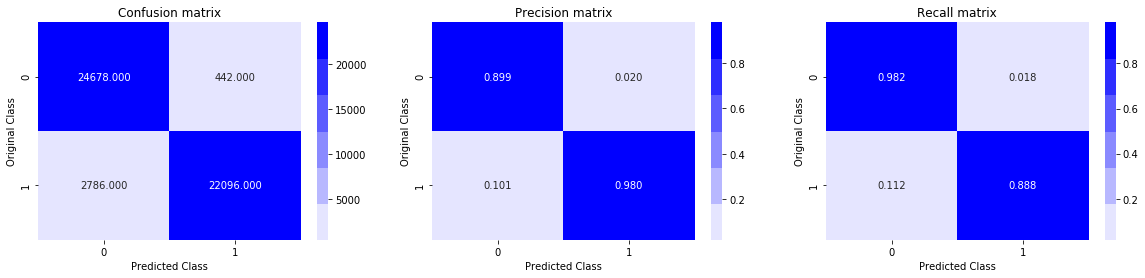

In [166]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

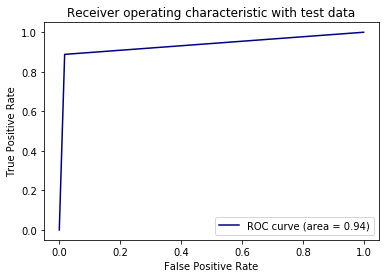

In [167]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

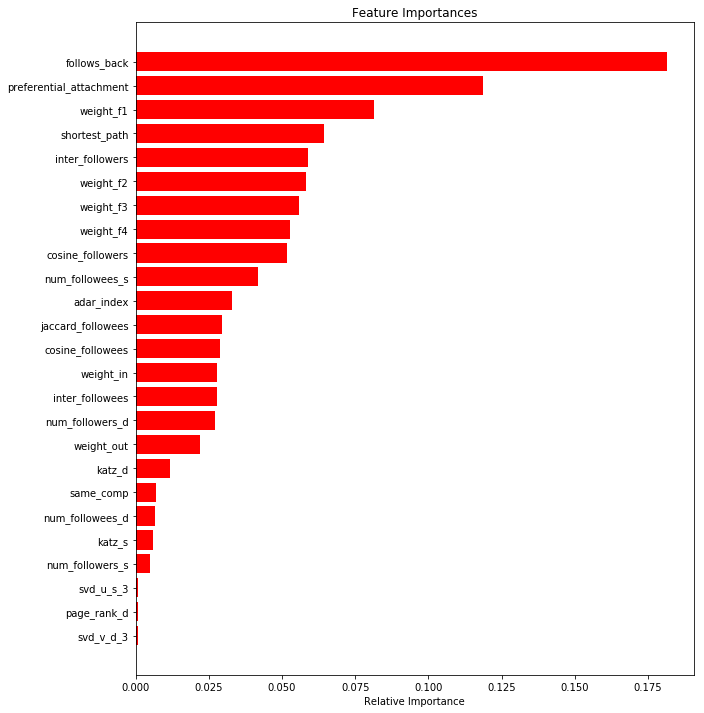

In [168]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## XGBoost With HyperParameter Tuning

In [169]:
%%time
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5 , 7 , 8],
        'n_estimators' : [10,30,50,70,90,120]
        }
xgb = XGBClassifier(learning_rate=0.02, eval_metric ='logloss',objective='binary:logistic',
                    silent=True, nthread=1)
folds = 3
param_comb = 5


random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=-1, cv=3, verbose=3, random_state=1001 )

random_search.fit(df_final_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:   25.6s remaining:   38.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:   46.5s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished


CPU times: user 45.1 s, sys: 252 ms, total: 45.4 s
Wall time: 1min 51s


In [170]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='logloss', gamma=0.5,
       learning_rate=0.02, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
       nthread=1, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
0.9568408631827363

 Best hyperparameters:
{'n_estimators': 70, 'colsample_bytree': 1.0, 'subsample': 0.6, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.5}


In [171]:
from sklearn.calibration import CalibratedClassifierCV
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='logloss', gamma=0.5,
       learning_rate=0.02, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
       nthread=1, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6)


xgb.fit(df_final_train, y_train)
sig_clf = CalibratedClassifierCV(xgb, method="sigmoid")
sig_clf.fit(df_final_train, y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='logloss', gamma=0.5,
       learning_rate=0.02, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
       nthread=1, objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6),
            cv='warn', method='sigmoid')

In [172]:
y_train_pred = sig_clf.predict(df_final_train)
y_test_pred = sig_clf.predict(df_final_test)

In [173]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9800382440129909
Test f1 score 0.9358950051612631


Train confusion_matrix


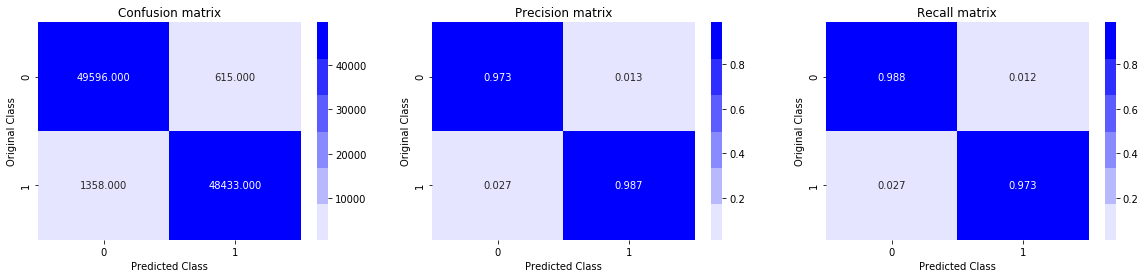

Test confusion_matrix


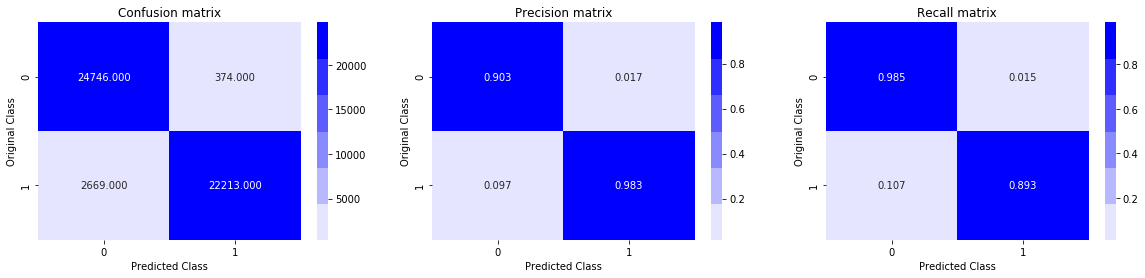

In [174]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

In [30]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names=['Model','Train f1 Score','Test f1 Score']
x.add_row(['Random Forest Classifier',0.9759,0.9319])
x.add_row(['XGBoost','0.9800',0.9358])
print(x)

+--------------------------+----------------+---------------+
|          Model           | Train f1 Score | Test f1 Score |
+--------------------------+----------------+---------------+
| Random Forest Classifier |     0.9759     |     0.9319    |
|         XGBoost          |     0.9800     |     0.9358    |
+--------------------------+----------------+---------------+


## Conclusions:

<ul>
    <li>1. We Used two models here :
        <ul>
            <li> Random Forest Classifier
                <li> XGBoost
        </ul>
        <li>2. We can see that XGBoost performs slightly better than Random Forest Classifier
            <li>3. Initially we have only two columns :
                <ul>
                    <li>Source Node
                        <li>Destination Node
                    </ul>
                        <li>4. Then we did some feature engineering and add some features
                            <li>5. Without adding features we can not get this f1 score
                                <li>6. Then we plotted Some histogram of our features
                                    <li>7. We Can see that our features have almost similar distribution
                                        <li>8. We also did tsne and it is clear that our data is mostly overlapping
    </ul>